In [1]:
#| default_exp single

🧬 Setting up initial population and configuration...
   - Founder population created with Mean TBV: 100.00

🚀 Preparing & running 5 replicates in parallel for 20 cycles each...
   - Simulation complete.

🔎 Analyzing results...
   - Mean TBV of final generation for each replicate:
     - Replicate 1: Initial TBV = 100.00 -> Final TBV = 120.34
     - Replicate 2: Initial TBV = 100.00 -> Final TBV = 117.37
     - Replicate 3: Initial TBV = 100.00 -> Final TBV = 117.86
     - Replicate 4: Initial TBV = 100.00 -> Final TBV = 119.96
     - Replicate 5: Initial TBV = 100.00 -> Final TBV = 117.57

   - Average Final TBV across all replicates: 118.62


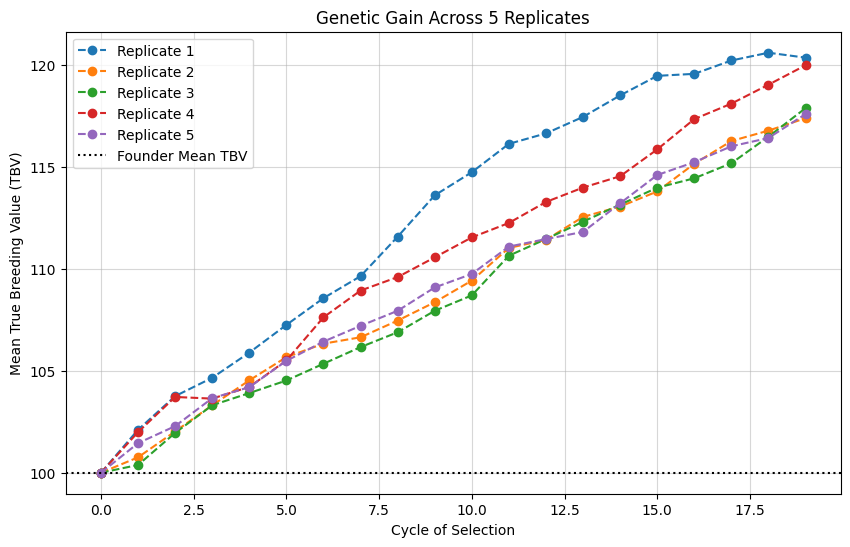


✅ Script finished successfully.


In [2]:
###CHEWC CODEBASE

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from flax.struct import dataclass
from typing import List, Optional
from jax import lax, vmap
from functools import partial

## --- 1. CORE DATA STRUCTURES ---
@dataclass(frozen=True)
class Population:
    geno: jnp.ndarray; meta: jnp.ndarray
@dataclass(frozen=True)
class Trait:
    qtl_chromosome: jnp.ndarray; qtl_position: jnp.ndarray; qtl_effects: jnp.ndarray; intercept: jnp.ndarray
@dataclass(frozen=True)
class StaticConfig:
    n_chr: int; n_loci_per_chr: int; ploidy: int; n_select: int; n_offspring: int
@dataclass(frozen=True)
class DynamicConfig:
    genetic_map: jnp.ndarray; traits: List[Trait]

## --- 2. HOST-SIDE SETUP FUNCTIONS ---
def create_founders(key: jax.random.PRNGKey, s_config: StaticConfig, n_founders: int) -> Population:
    geno = jax.random.randint(key, (n_founders, s_config.n_chr, s_config.ploidy, s_config.n_loci_per_chr), 0, 2, dtype=jnp.int8)
    ids = jnp.arange(n_founders, dtype=jnp.int32)[:, None]
    parent_ids = jnp.full((n_founders, 2), -1, dtype=jnp.int32)
    birth_gen = jnp.zeros((n_founders, 1), dtype=jnp.int32)
    return Population(geno=geno, meta=jnp.hstack([ids, parent_ids, birth_gen]))

def add_trait(key: jax.random.PRNGKey, founder_pop: Population, s_config: StaticConfig, d_config: DynamicConfig, n_qtl_per_chr: int, mean: jnp.ndarray, var: jnp.ndarray) -> DynamicConfig:
    key, qtl_key, effect_key = jax.random.split(key, 3)
    n_total_qtl = n_qtl_per_chr * s_config.n_chr
    all_loci_indices = jnp.arange(s_config.n_chr * s_config.n_loci_per_chr)
    qtl_loc_flat = jax.random.choice(qtl_key, all_loci_indices, (n_total_qtl,), replace=False)
    qtl_chromosome, qtl_position = jnp.divmod(jnp.sort(qtl_loc_flat), s_config.n_loci_per_chr)
    raw_effects = jax.random.normal(effect_key, (n_total_qtl, mean.shape[0]))
    correlated_raw_effects = raw_effects @ jnp.linalg.cholesky(jnp.identity(mean.shape[0]))
    temp_trait = Trait(qtl_chromosome, qtl_position, correlated_raw_effects, jnp.zeros_like(mean))
    founder_dosage = jnp.sum(founder_pop.geno, axis=2, dtype=jnp.int8)
    initial_gvs = jnp.dot(founder_dosage[:, qtl_chromosome, qtl_position], correlated_raw_effects)
    scaling_factors = jnp.sqrt(var / (jnp.var(initial_gvs, axis=0) + 1e-8))
    final_intercepts = mean - (jnp.mean(initial_gvs, axis=0) * scaling_factors)
    final_add_eff = correlated_raw_effects * scaling_factors
    final_trait = Trait(qtl_chromosome, qtl_position, final_add_eff, final_intercepts)
    return d_config.replace(traits=[final_trait])

## --- 3. MEIOSIS AND SIMULATION KERNELS ---
_get_locus_positions = jax.jit(lambda genetic_map: jnp.cumsum(genetic_map, axis=-1))

def _sample_chiasmata(key: jax.random.PRNGKey, map_length: jnp.ndarray, v_interference: float, max_crossovers: int) -> jnp.ndarray:
    shape, scale = v_interference, 1.0 / (2.0 * v_interference)
    def scan_body(carry, _):
        key, last_pos = carry; key, subkey = jax.random.split(key)
        new_pos = last_pos + jax.random.gamma(subkey, shape) * scale; return (key, new_pos), new_pos
    key, initial_key = jax.random.split(key); init_carry = (key, jax.random.uniform(initial_key, minval=-1.0, maxval=0.0))
    _, crossover_positions = lax.scan(scan_body, init_carry, None, length=max_crossovers)
    return jnp.where((crossover_positions > 0) & (crossover_positions < map_length), crossover_positions, jnp.inf)

def _create_gamete_for_chromosome(key: jax.random.PRNGKey, parental_haplotypes: jnp.ndarray, locus_positions: jnp.ndarray, v_interference: float, max_crossovers: int) -> jnp.ndarray:
    key, chiasma_key, hap_key = jax.random.split(key, 3)
    sorted_crossovers = jnp.sort(_sample_chiasmata(chiasma_key, locus_positions[-1], v_interference, max_crossovers))
    locus_segments = jnp.searchsorted(sorted_crossovers, locus_positions, side="right")
    start_hap = jax.random.choice(hap_key, jnp.array([0, 1], dtype=jnp.uint8))
    haplotype_choice = (start_hap + locus_segments) % 2
    return jnp.where(haplotype_choice == 0, parental_haplotypes[0], parental_haplotypes[1])

def _cross_pair(key: jax.random.PRNGKey, mother_geno: jnp.ndarray, father_geno: jnp.ndarray, locus_positions: jnp.ndarray, n_chr: int, v_interference: float, max_crossovers: int) -> jnp.ndarray:
    key_mother, key_father = jax.random.split(key)
    vmapped_gamete_creator = vmap(_create_gamete_for_chromosome, in_axes=(0, 0, 0, None, None))
    mother_gamete = vmapped_gamete_creator(jax.random.split(key_mother, n_chr), mother_geno, locus_positions, v_interference, max_crossovers)
    father_gamete = vmapped_gamete_creator(jax.random.split(key_father, n_chr), father_geno, locus_positions, v_interference, max_crossovers)
    return jnp.stack([mother_gamete, father_gamete], axis=1)

# --- FIX WAS HERE: Removed the nested @jit from this helper function ---
def create_offspring(key: jax.random.PRNGKey, parent_population: Population, pairings: jnp.ndarray, s_config: StaticConfig, d_config: DynamicConfig, current_gen: int, max_crossovers: int = 20, v_interference: float = 2.5) -> Population:
    n_crosses, n_chr = pairings.shape[0], s_config.n_chr
    mother_indices, father_indices = pairings[:, 0], pairings[:, 1]
    mothers_geno, fathers_geno = parent_population.geno[mother_indices], parent_population.geno[father_indices]
    locus_positions = _get_locus_positions(d_config.genetic_map)
    offspring_geno = vmap(_cross_pair, in_axes=(0, 0, 0, None, None, None, None))(
        jax.random.split(key, n_crosses), mothers_geno, fathers_geno, locus_positions, n_chr, v_interference, max_crossovers)
    offspring_ids = jnp.arange(n_crosses, dtype=jnp.int32)[:, None]
    mother_ids, father_ids = parent_population.meta[mother_indices, 0], parent_population.meta[father_indices, 0]
    birth_gen = jnp.full((n_crosses, 1), current_gen, dtype=jnp.int32)
    return Population(geno=offspring_geno, meta=jnp.hstack([offspring_ids, jnp.stack([mother_ids, father_ids], axis=1), birth_gen]))

def generation_step(carry, gen_idx: int, s_config: StaticConfig, h2: float):
    current_pop, key, d_config = carry
    key, pheno_key, mate_key, cross_key = jax.random.split(key, 4)
    dosage = jnp.sum(current_pop.geno, axis=2, dtype=jnp.int8)
    trait = d_config.traits[0]
    tbv = jnp.dot(dosage[:, trait.qtl_chromosome, trait.qtl_position], trait.qtl_effects) + trait.intercept
    genetic_variance = jnp.var(tbv, axis=0)
    var_e = genetic_variance * (1.0 / (h2 + 1e-8) - 1.0)
    phenotypes = tbv + jax.random.normal(pheno_key, tbv.shape) * jnp.sqrt(jnp.maximum(0, var_e))
    top_parent_indices = jnp.argsort(phenotypes.flatten())[-s_config.n_select:]
    selected_parents_pop = jax.tree.map(lambda x: x[top_parent_indices], current_pop)
    parent_pool_indices = jnp.arange(s_config.n_select)
    mothers = jax.random.choice(mate_key, parent_pool_indices, (s_config.n_offspring,))
    fathers = jax.random.choice(mate_key, parent_pool_indices, (s_config.n_offspring,))
    fathers = jnp.where(mothers == fathers, (fathers + 1) % s_config.n_select, fathers)
    pairings = jnp.stack([mothers, fathers], axis=1)
    offspring_pop = create_offspring(cross_key, selected_parents_pop, pairings, s_config, d_config, current_gen=gen_idx + 1)
    return (offspring_pop, key, d_config), {'mean_tbv': jnp.mean(tbv)}

@partial(jax.jit, static_argnames=('s_config', 'n_cycles', 'h2'))
def run_simulation(initial_pop: Population, initial_key: jax.random.PRNGKey, s_config: StaticConfig, d_config: DynamicConfig, n_cycles: int, h2: float):
    scan_body = lambda carry, gen_idx: generation_step(carry, gen_idx, s_config=s_config, h2=h2)
    initial_carry = (initial_pop, initial_key, d_config)
    (final_pop, _, _), history = lax.scan(scan_body, initial_carry, jnp.arange(n_cycles))
    return final_pop, history

## --- 4. MAIN EXPERIMENT SCRIPT ---
if __name__ == '__main__':
    print("🧬 Setting up initial population and configuration...")
    master_key = jax.random.PRNGKey(42)
    n_founders, n_replicates, n_cycles, h2 = 50, 5, 20, 0.2
    
    s_config = StaticConfig(n_chr=10, n_loci_per_chr=100, ploidy=2, n_select=20, n_offspring=50)
    d_config = DynamicConfig(genetic_map=jnp.full((s_config.n_chr, s_config.n_loci_per_chr), 0.01), traits=[])
    
    founder_pop = create_founders(master_key, s_config, n_founders)
    final_d_config = add_trait(master_key, founder_pop, s_config, d_config, 10, jnp.array([100.0]), jnp.array([10.0]))
    
    trait = final_d_config.traits[0]
    initial_tbv_mean = jnp.mean(jnp.dot(jnp.sum(founder_pop.geno, axis=2)[:, trait.qtl_chromosome, trait.qtl_position], trait.qtl_effects) + trait.intercept)
    print(f"   - Founder population created with Mean TBV: {initial_tbv_mean:.2f}")

    print(f"\n🚀 Preparing & running {n_replicates} replicates in parallel for {n_cycles} cycles each...")
    replicate_keys = jax.random.split(master_key, n_replicates)
    
    sim_partial = partial(run_simulation, n_cycles=n_cycles, h2=h2)
    vmapped_simulation = vmap(sim_partial, in_axes=(None, 0, None, None))
    
    final_pops, history = vmapped_simulation(founder_pop, replicate_keys, s_config, final_d_config)
    
    print("   - Simulation complete.")
    print("\n🔎 Analyzing results...")
    
    final_tbvs = history['mean_tbv'][:, -1]
    print("   - Mean TBV of final generation for each replicate:")
    for i in range(n_replicates):
        print(f"     - Replicate {i+1}: Initial TBV = {initial_tbv_mean:.2f} -> Final TBV = {final_tbvs[i]:.2f}")
    
    print(f"\n   - Average Final TBV across all replicates: {jnp.mean(final_tbvs):.2f}")

    plt.figure(figsize=(10, 6))
    for i in range(n_replicates):
        plt.plot(np.array(history['mean_tbv'][i]), marker='o', linestyle='--', label=f'Replicate {i+1}')
    plt.axhline(float(initial_tbv_mean), color='black', linestyle=':', label='Founder Mean TBV')
    plt.title(f'Genetic Gain Across {n_replicates} Replicates'); plt.xlabel('Cycle of Selection')
    plt.ylabel('Mean True Breeding Value (TBV)'); plt.legend(); plt.grid(True, alpha=0.5); plt.show()

    print("\n✅ Script finished successfully.")


🧬 Setting up initial population and configuration...
   - Founder population created with Mean TBV: 100.00

🚀 Preparing & running 5 replicates in parallel for 20 cycles each...
   - Simulation complete.

🔎 Analyzing results (selection by EBV).
   - Mean TBV of final generation for each replicate:
     - Replicate 1: Initial TBV = 100.00 -> Final TBV = 118.49
     - Replicate 2: Initial TBV = 100.00 -> Final TBV = 120.94
     - Replicate 3: Initial TBV = 100.00 -> Final TBV = 122.19
     - Replicate 4: Initial TBV = 100.00 -> Final TBV = 120.83
     - Replicate 5: Initial TBV = 100.00 -> Final TBV = 117.88

   - Average Final TBV across all replicates: 120.07
   - Average final selection score (EBV mean): -0.00


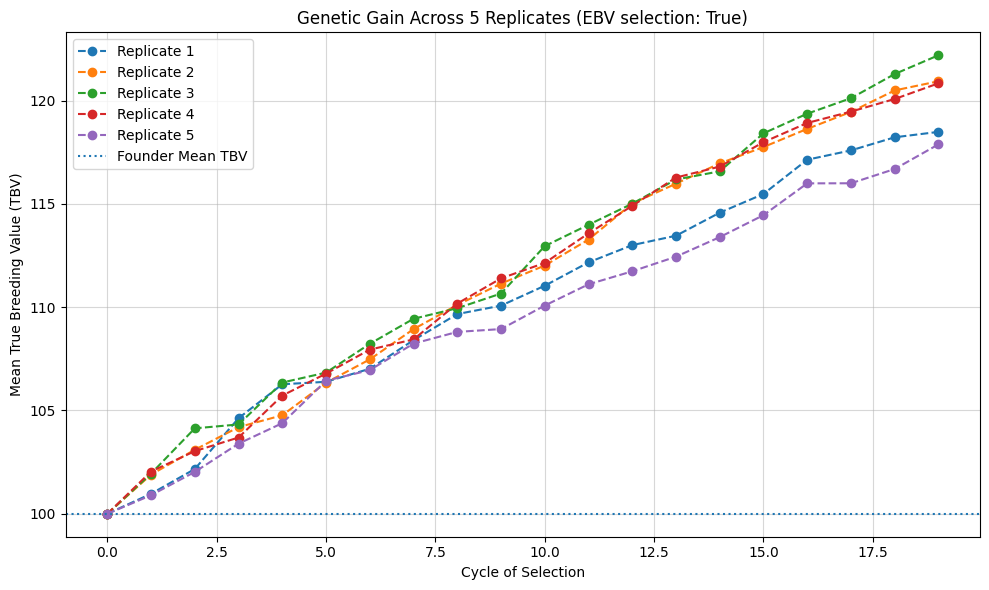


✅ Script finished successfully.


In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from flax.struct import dataclass
from typing import Tuple, Optional
from jax import lax, vmap
from functools import partial

# Optional: better numeric stability on GPUs/TPUs for solves
try:
    from jax import config as jax_config
    jax_config.update("jax_default_matmul_precision", "high")
except Exception:
    pass

# ===============================
# 1) CORE DATA STRUCTURES
# ===============================
@dataclass(frozen=True)
class Population:
    # geno: (N, n_chr, ploidy=2, n_loci)
    geno: jnp.ndarray
    # meta columns: [id, mother_id, father_id, birth_gen]
    meta: jnp.ndarray

@dataclass(frozen=True)
class Trait:
    # QTL location and additive effects across traits
    qtl_chromosome: jnp.ndarray   # (Q,)
    qtl_position: jnp.ndarray     # (Q,)
    qtl_effects: jnp.ndarray      # (Q, n_traits)
    intercept: jnp.ndarray        # (n_traits,)

@dataclass(frozen=True)
class StaticConfig:
    n_chr: int
    n_loci_per_chr: int
    ploidy: int
    n_select: int
    n_offspring: int

@dataclass(frozen=True)
class DynamicConfig:
    genetic_map: jnp.ndarray              # (n_chr, n_loci)
    traits: Tuple[Trait, ...]             # tuple for pytree stability
    locus_positions: jnp.ndarray          # (n_chr, n_loci), cumsum of genetic_map


# ===============================
# 2) HOST-SIDE SETUP FUNCTIONS
# ===============================

def create_founders(key: jax.random.PRNGKey, s_config: StaticConfig, n_founders: int) -> Population:
    geno = jax.random.randint(
        key,
        (n_founders, s_config.n_chr, s_config.ploidy, s_config.n_loci_per_chr),
        0,
        2,
        dtype=jnp.int8,
    )
    ids = jnp.arange(n_founders, dtype=jnp.int32)[:, None]
    parent_ids = jnp.full((n_founders, 2), -1, dtype=jnp.int32)
    birth_gen = jnp.zeros((n_founders, 1), dtype=jnp.int32)
    return Population(geno=geno, meta=jnp.hstack([ids, parent_ids, birth_gen]))




# ===============================
# 3) MEIOSIS AND SIMULATION KERNELS
# ===============================



# ===============================
# 4) GBLUP HELPERS (VanRaden GRM + closed-form BLUP)
# ===============================

def compute_dosage(pop: Population) -> jnp.ndarray:
    # (N, C, P, L) -> sum over ploidy -> (N, C, L) float32
    return jnp.sum(pop.geno, axis=2).astype(jnp.float32)


def gather_qtl_dosage(dosage: jnp.ndarray, trait: Trait) -> jnp.ndarray:
    # dosage: (N, C, L) -> (N, Q) at QTL positions
    return dosage[:, trait.qtl_chromosome, trait.qtl_position]


def vanraden_grm(M: jnp.ndarray) -> jnp.ndarray:
    """
    M: (N, Q) marker dosage in {0,1,2}
    VanRaden I: Z = M - 2p, K = ZZ' / (2 * sum p(1-p))
    """
    p = jnp.mean(M, axis=0) / 2.0                     # (Q,)
    Z = M - 2.0 * p                                   # center
    denom = 2.0 * jnp.sum(p * (1.0 - p)) + 1e-8
    return (Z @ Z.T) / denom                          # (N, N)


def gblup_fit(K: jnp.ndarray, y: jnp.ndarray, h2: float) -> jnp.ndarray:
    """Solve (K + λI) α = ỹ, then û = K α. y is (N,)"""
    lam = (1.0 - h2) / (h2 + 1e-8)
    y_tilde = y - jnp.mean(y)
    A = K + lam * jnp.eye(K.shape[0], dtype=K.dtype)
    alpha = jnp.linalg.solve(A, y_tilde)
    u_hat = K @ alpha
    return u_hat


# ===============================
# 5) ONE GENERATION STEP (uses EBVs when use_gblup=True)
# ===============================

def generation_step(carry, gen_idx: int, s_config: StaticConfig, h2: float, use_gblup: bool = True):
    current_pop, key, d_config, next_id = carry

    # keys: keep streams independent
    key, pheno_key, mate_key, cross_key = jax.random.split(key, 4)
    mate_key_m, mate_key_f = jax.random.split(mate_key)

    # genotype dosage
    dosage = compute_dosage(current_pop)  # (N, C, L)

    # TBV from hidden QTL
    trait = d_config.traits[0]
    G_Q = gather_qtl_dosage(dosage, trait)                 # (N, Q)
    tbv = (G_Q @ trait.qtl_effects + trait.intercept).squeeze()  # (N,) for 1-trait

    # phenotype generation
    genetic_variance = jnp.var(tbv)
    var_e = genetic_variance * (1.0 / (h2 + 1e-8) - 1.0)
    y = tbv + jax.random.normal(pheno_key, tbv.shape) * jnp.sqrt(jnp.maximum(0.0, var_e))

    # selection scores
    if use_gblup:
        # Use all loci as markers (more realistic). Flatten (N, C, L) -> (N, C*L)
        M = dosage.reshape(dosage.shape[0], -1)
        K = vanraden_grm(M)
        ebv = gblup_fit(K, y, h2)  # (N,)
        scores = ebv
    else:
        scores = y

    # choose top parents
    top_parent_indices = jnp.argsort(scores)[-s_config.n_select:]

    selected_parents_pop = jax.tree_util.tree_map(lambda x: x[top_parent_indices], current_pop)

    parent_pool_indices = jnp.arange(s_config.n_select)
    mothers = jax.random.choice(mate_key_m, parent_pool_indices, (s_config.n_offspring,))
    fathers = jax.random.choice(mate_key_f, parent_pool_indices, (s_config.n_offspring,))
    fathers = jnp.where(mothers == fathers, (fathers + 1) % s_config.n_select, fathers)
    pairings = jnp.stack([mothers, fathers], axis=1)

    offspring_pop = create_offspring(
        cross_key, selected_parents_pop, pairings, s_config, d_config, current_gen=gen_idx + 1, next_id_start=next_id
    )

    new_next_id = next_id + s_config.n_offspring
    history_row = {
        'mean_tbv': jnp.mean(tbv),
        'mean_pheno': jnp.mean(y),
        'mean_score': jnp.mean(scores),
    }
    return (offspring_pop, key, d_config, new_next_id), history_row


@partial(jax.jit, static_argnames=(
    's_config', 'n_cycles', 'use_gblup'
))
def run_simulation(
    initial_pop: Population,
    initial_key: jax.random.PRNGKey,
    s_config: StaticConfig,
    d_config: DynamicConfig,
    n_cycles: int,
    h2: float,
    use_gblup: bool = True,
):
    scan_body = lambda carry, gen_idx: generation_step(carry, gen_idx, s_config=s_config, h2=h2, use_gblup=use_gblup)

    # next_id starts after founders
    next_id0 = int(initial_pop.geno.shape[0])
    initial_carry = (initial_pop, initial_key, d_config, next_id0)

    (final_pop, _, _, _), history = lax.scan(scan_body, initial_carry, jnp.arange(n_cycles))
    return final_pop, history


# ===============================
# 6) MAIN EXPERIMENT SCRIPT
# ===============================
if __name__ == '__main__':
    print("\n🧬 Setting up initial population and configuration...")
    master_key = jax.random.PRNGKey(42)

    # Independent key streams (avoid reuse)
    master_key, founders_key, trait_key, sims_key = jax.random.split(master_key, 4)

    # Experiment knobs
    n_founders = 50
    n_replicates = 5
    n_cycles = 20
    h2 = 0.2
    use_gblup = True  # <-- use EBVs for selection

    s_config = StaticConfig(n_chr=10, n_loci_per_chr=100, ploidy=2, n_select=20, n_offspring=50)

    genetic_map = jnp.full((s_config.n_chr, s_config.n_loci_per_chr), 0.01)
    locus_positions = jnp.cumsum(genetic_map, axis=-1)
    d_config = DynamicConfig(genetic_map=genetic_map, traits=tuple(), locus_positions=locus_positions)

    founder_pop = create_founders(founders_key, s_config, n_founders)

    # one trait with target mean/var
    final_d_config = add_trait(
        trait_key,
        founder_pop,
        s_config,
        d_config,
        n_qtl_per_chr=10,
        mean=jnp.array([100.0], dtype=jnp.float32),
        var=jnp.array([10.0], dtype=jnp.float32),
        Sigma=None,
    )

    # compute initial mean TBV
    trait = final_d_config.traits[0]
    founder_dosage = jnp.sum(founder_pop.geno, axis=2).astype(jnp.float32)
    initial_tbv = (founder_dosage[:, trait.qtl_chromosome, trait.qtl_position] @ trait.qtl_effects + trait.intercept).squeeze()
    initial_tbv_mean = jnp.mean(initial_tbv)

    print(f"   - Founder population created with Mean TBV: {float(initial_tbv_mean):.2f}")

    print(f"\n🚀 Preparing & running {n_replicates} replicates in parallel for {n_cycles} cycles each...")

    # One independent key per replicate (fold_in is robust under vmap)
    replicate_keys = jax.vmap(lambda i: jax.random.fold_in(sims_key, i))(jnp.arange(n_replicates))

    sim_partial = partial(run_simulation, n_cycles=n_cycles, use_gblup=use_gblup, h2=h2)
    vmapped_simulation = vmap(sim_partial, in_axes=(None, 0, None, None))

    final_pops, history = vmapped_simulation(founder_pop, replicate_keys, s_config, final_d_config)

    print("   - Simulation complete.")
    print("\n🔎 Analyzing results (selection by EBV).")

    # history fields are arrays over cycles; take last
    final_tbvs = history['mean_tbv'][:, -1]
    final_scores = history['mean_score'][:, -1]

    print("   - Mean TBV of final generation for each replicate:")
    for i in range(n_replicates):
        print(f"     - Replicate {i+1}: Initial TBV = {float(initial_tbv_mean):.2f} -> Final TBV = {float(final_tbvs[i]):.2f}")

    print(f"\n   - Average Final TBV across all replicates: {float(jnp.mean(final_tbvs)):.2f}")
    print(f"   - Average final selection score (EBV mean): {float(jnp.mean(final_scores)):.2f}")

    # Plot genetic gain per replicate
    plt.figure(figsize=(10, 6))
    for i in range(n_replicates):
        plt.plot(np.array(history['mean_tbv'][i]), marker='o', linestyle='--', label=f'Replicate {i+1}')
    plt.axhline(float(initial_tbv_mean), linestyle=':', label='Founder Mean TBV')
    plt.title(f'Genetic Gain Across {n_replicates} Replicates (EBV selection: {use_gblup})')
    plt.xlabel('Cycle of Selection')
    plt.ylabel('Mean True Breeding Value (TBV)')
    plt.legend()
    plt.grid(True, alpha=0.5)
    plt.tight_layout()
    plt.show()

    print("\n✅ Script finished successfully.")


In [4]:
#| hide
import nbdev; nbdev.nbdev_export()